In [44]:
pip install pandas scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns

In [46]:
# Cargar el dataset desde una hoja de Excel
data = pd.read_excel('DATASET.xlsx')

# Explorar el dataset
print(data.head())

   Subestacion      Alimentadora     fecha_hora_desc     fecha_hora_rest  \
0      Samanes         Samanes 4 2019-01-01 07:36:51 2019-01-01 07:37:02   
1     Alborada  Benjamín Carrión 2019-01-02 13:16:28 2019-01-02 13:16:43   
2      Safando           Capeira 2019-01-06 21:20:54 2019-01-06 21:21:09   
3  Las Cumbres      Sta. Cecilia 2019-01-10 16:04:36 2019-01-10 16:04:49   
4  Las Cumbres      Sta. Cecilia 2019-01-11 05:15:43 2019-01-11 05:16:21   

   duracion_seg  Fase A  Fase B  Fase C  ICC Fase A  ICC Fase B  ICC Fase C  \
0          11.0     166     162     166        2829         166        3115   
1          15.0     209     214     197         219        3480         241   
2          15.0      98      84      81        3233        3401         106   
3          13.0     254     244     245         234         206        1145   
4          38.0     196     192     191         157        4279        4197   

                            Causa  
0  Árboles o ramas hacen contact

In [47]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Subestacion      1167 non-null   object        
 1   Alimentadora     1167 non-null   object        
 2   fecha_hora_desc  1167 non-null   datetime64[ns]
 3   fecha_hora_rest  1167 non-null   datetime64[ns]
 4   duracion_seg     1167 non-null   float64       
 5   Fase A           1167 non-null   int64         
 6   Fase B           1167 non-null   int64         
 7   Fase C           1167 non-null   int64         
 8   ICC Fase A       1167 non-null   int64         
 9   ICC Fase B       1167 non-null   int64         
 10  ICC Fase C       1167 non-null   int64         
 11  Causa            1167 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(6), object(3)
memory usage: 109.5+ KB
None
       duracion_seg       Fase A       Fase B       Fase C    I

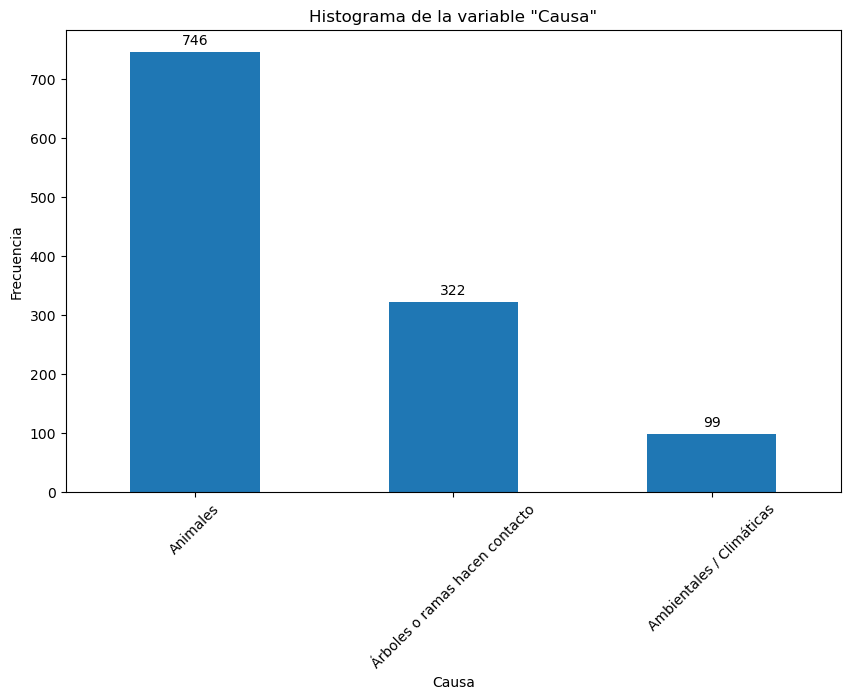

In [48]:
# Histograma para la variable "Causa"
plt.figure(figsize=(10, 6))
causa_counts = data['Causa'].value_counts()
bars = causa_counts.plot(kind='bar')

# Total de registros sobre cada barra
for bar in bars.patches:
    height = bar.get_height()
    plt.annotate(f'{height}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points", 
                 ha='center', va='bottom')

plt.xlabel('Causa')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable "Causa"')
plt.xticks(rotation=45)
plt.show()

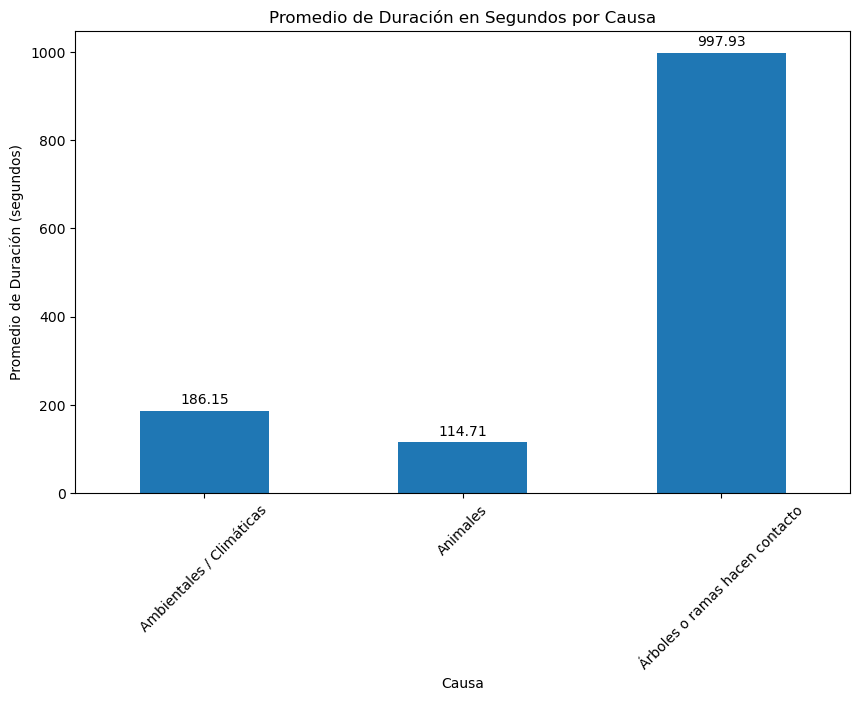

In [49]:
# Calcular el promedio de duracion_seg para cada causa
mean_durations = data.groupby('Causa')['duracion_seg'].mean()

# Crear un gráfico de barras para los promedios
plt.figure(figsize=(10, 6))
bars = mean_durations.plot(kind='bar')

# Agregar anotaciones sobre cada barra
for bar in bars.patches:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points", 
                 ha='center', va='bottom')

plt.xlabel('Causa')
plt.ylabel('Promedio de Duración (segundos)')
plt.title('Promedio de Duración en Segundos por Causa')
plt.xticks(rotation=45)
plt.show()

In [50]:
# Utilizamos la matriz de correlaciones entre variables
data.corr()

C:\Users\gach8\AppData\Local\Temp\ipykernel_18036\3810333528.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,duracion_seg,Fase A,Fase B,Fase C,ICC Fase A,ICC Fase B,ICC Fase C
duracion_seg,1.000000,-0.082012,-0.077613,-0.080350,0.025821,0.033586,0.051869
Fase A,-0.082012,1.000000,0.938652,0.842134,0.004711,-0.032876,0.001319
Fase B,-0.077613,0.938652,1.000000,0.848673,0.015056,-0.010554,-0.009101
Fase C,-0.080350,0.842134,0.848673,1.000000,0.009971,-0.032032,-0.019312
ICC Fase A,0.025821,0.004711,0.015056,0.009971,1.000000,-0.174846,-0.317667
ICC Fase B,0.033586,-0.032876,-0.010554,-0.032032,-0.174846,1.000000,-0.065892
ICC Fase C,0.051869,0.001319,-0.009101,-0.019312,-0.317667,-0.065892,1.000000


In [51]:
# Convertir las columnas 'fecha_hora_desc' y 'fecha_hora_rest' a formato datetime
data['fecha_hora_desc'] = pd.to_datetime(data['fecha_hora_desc'])
data['fecha_hora_rest'] = pd.to_datetime(data['fecha_hora_rest'])


In [52]:
# Codificar la variable categórica 'subestacion'
le_Subestacion = LabelEncoder()
data['Subestacion'] = le_Subestacion.fit_transform(data['Subestacion'])

# Codificar la variable a predecir 'alimentadora'
le_Alimentadora = LabelEncoder()
data['Alimentadora'] = le_Alimentadora.fit_transform(data['Alimentadora'])

# Codificar la variable a predecir 'Tipo de falla'
le_Causa = LabelEncoder()
data['Causa'] = le_Causa.fit_transform(data['Causa'])



In [53]:
# Separar variables predictoras y variable objetivo
X = data.drop(columns = ['Causa','fecha_hora_desc', 'fecha_hora_rest'])
y = data['Causa']

In [54]:
# Seleccionar solo las columnas numéricas para estandarizar
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

In [55]:
# Estandarizar las variables numéricas
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [56]:
# Paso 3: Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# TÉCNICA DE RANDOM FOREST

C:\Users\gach8\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\gach8\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\gach8\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\gach8\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\gach8\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probab

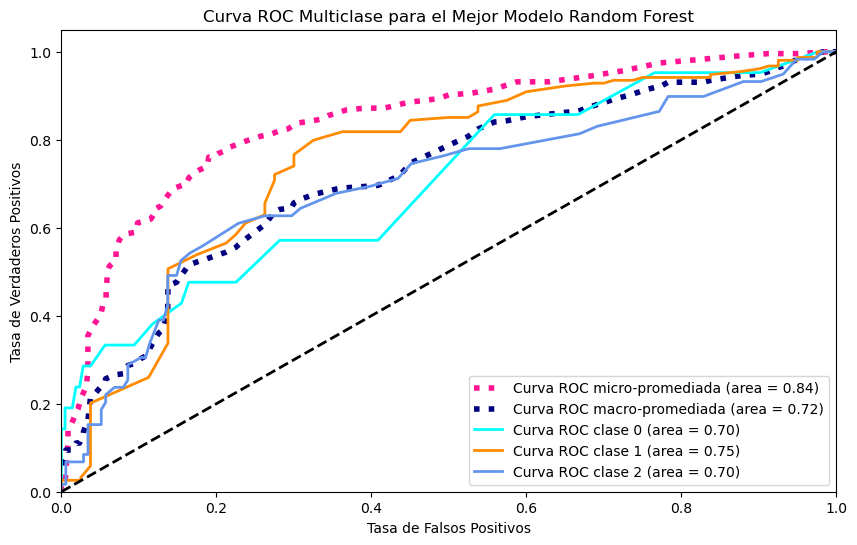

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarizar las etiquetas para que cada clase sea considerada como "una contra el resto"
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Obtener el modelo Random Forest entrenado con el menor error OOB
n_trees_range = range(1, 100)
oob_errors = []
models = []

for n_trees in n_trees_range:
    rf_model = RandomForestClassifier(n_estimators=n_trees, oob_score=True, max_depth=100, max_features='log2', random_state=42)
    rf_model.fit(X_train, y_train)
    oob_error = 1 - rf_model.oob_score_
    oob_errors.append(oob_error)
    models.append(rf_model)

best_index = oob_errors.index(min(oob_errors))
best_rf_model = models[best_index]

# Predecir las probabilidades para el conjunto de prueba
y_score = best_rf_model.predict_proba(X_test)

# Inicializar las variables para la curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular la curva ROC y AUC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (micro y macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Curva ROC micro-promediada (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Curva ROC macro-promediada (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC clase {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase para el Mejor Modelo Random Forest')
plt.legend(loc="lower right")
plt.show()

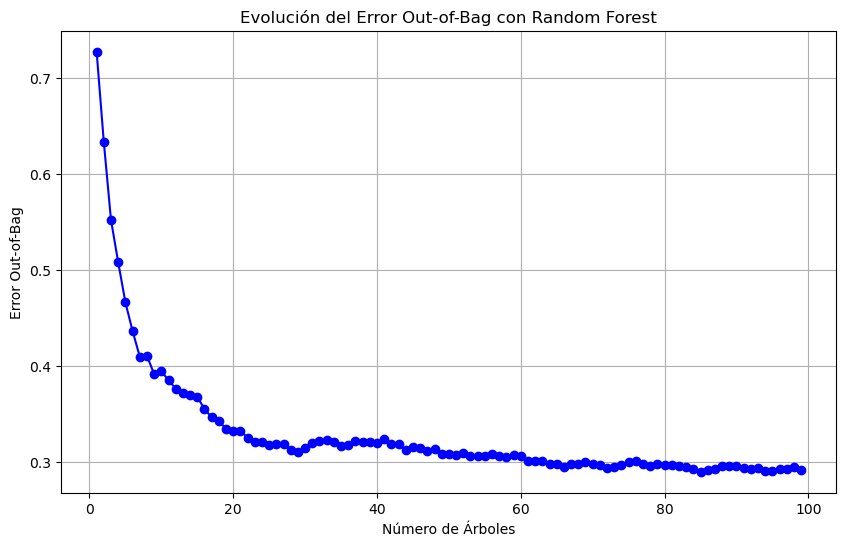

In [59]:
# Visualizar la evolución del error OOB
plt.figure(figsize=(10, 6))
plt.plot(n_trees_range, oob_errors, marker='o', linestyle='-', color='b')
plt.title('Evolución del Error Out-of-Bag con Random Forest')
plt.xlabel('Número de Árboles')
plt.ylabel('Error Out-of-Bag')
plt.grid(True)
plt.show()

In [60]:
rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.7094017094017094


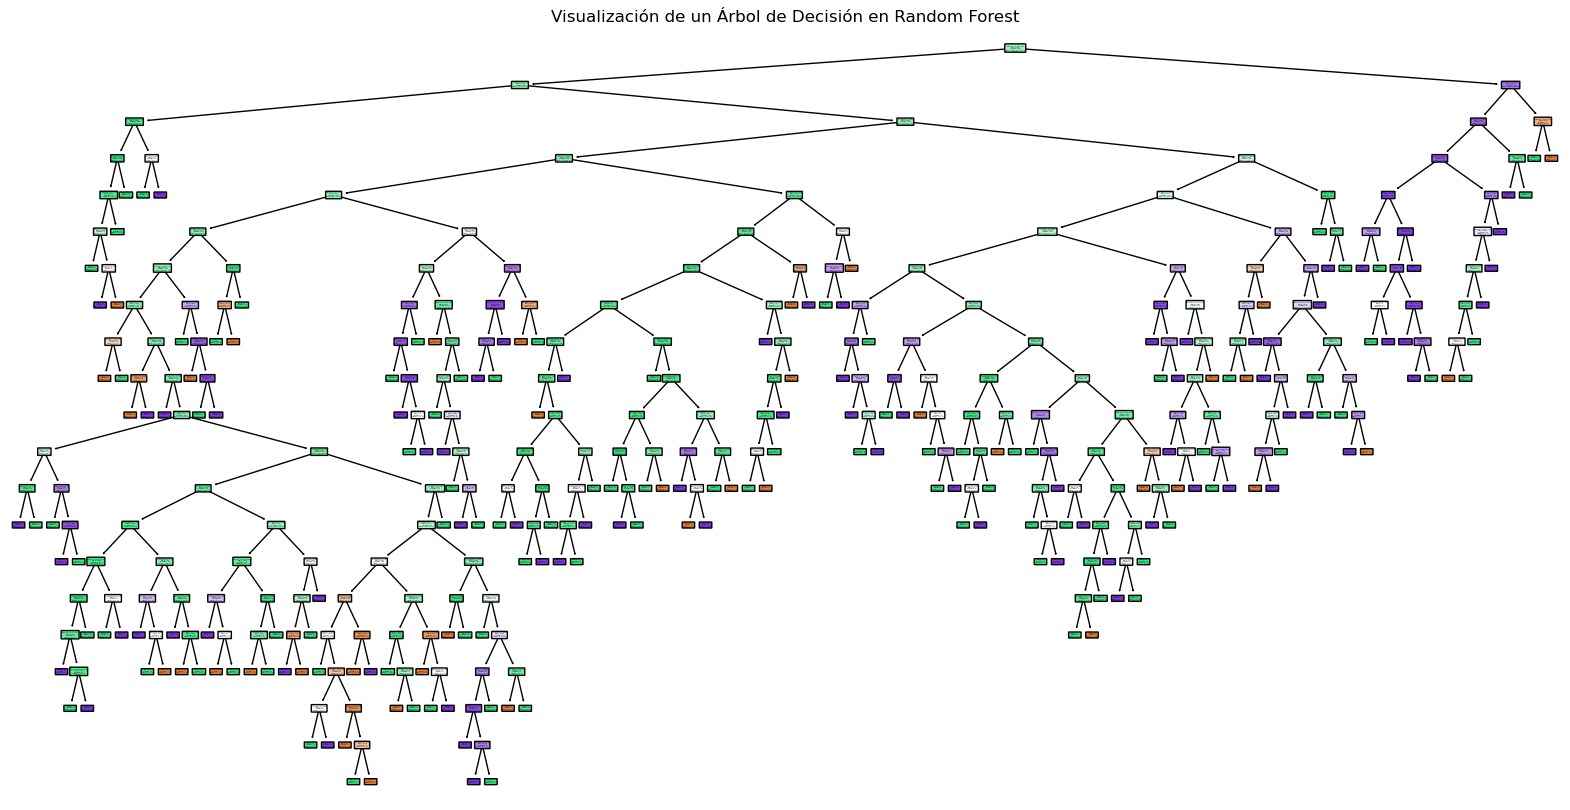

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Seleccionar un árbol individual del modelo Random Forest (por ejemplo, el primer árbol)
estimator = best_rf_model.estimators_[0]  # El primer árbol del mejor modelo

# Graficar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(estimator, filled=True, feature_names=X_train.columns, class_names=np.unique(y_train).astype(str), rounded=True)
plt.title("Visualización de un Árbol de Decisión en Random Forest")
plt.show()

# MODELO DE SUPPORT VECTOR MACHINE

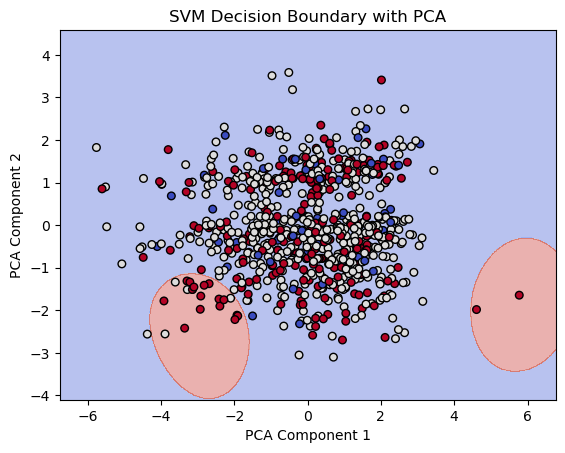

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Eliminar las columnas "fecha_hora_desc" del dataset
data = data.drop(columns=['fecha_hora_desc', 'fecha_hora_rest'])

# Asumiendo que `data` contiene todas las características y la variable 'Causa'
X = data.drop(columns=['Causa'])
y = data['Causa']

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Dividir los datos en entrenamiento y prueba
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Definir los parámetros del modelo SVM
svm_model = SVC(kernel='rbf', gamma='scale', C=1, random_state=42, probability=True)

# Entrenar el modelo con los datos transformados por PCA
svm_model.fit(X_train_pca, y_train)



# Definir los límites de la gráfica
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predecir en cada punto de la malla
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Graficar la frontera de decisión
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)

# Graficar las instancias de entrenamiento
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=30, cmap=plt.cm.coolwarm, edgecolors='k')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title("SVM Decision Boundary with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

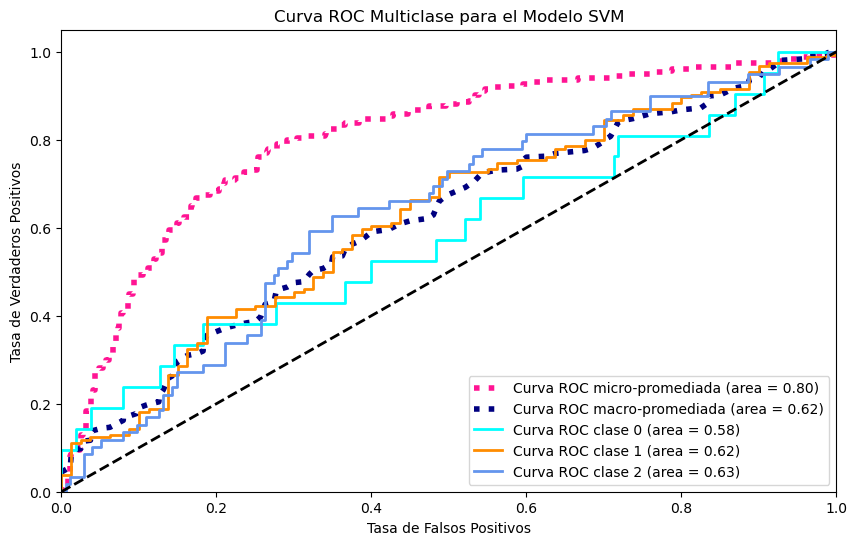

In [62]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarizar las etiquetas para que cada clase sea considerada como "una contra el resto"
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Entrenar el modelo SVM con probabilidad (si no está ya entrenado)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predecir las probabilidades para el conjunto de prueba
y_score = svm_model.predict_proba(X_test)

# Inicializar las variables para la curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular la curva ROC y AUC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (micro y macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Curva ROC micro-promediada (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Curva ROC macro-promediada (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC clase {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase para el Modelo SVM')
plt.legend(loc="lower right")
plt.show()

In [65]:
# Obtener los pesos (componentes) de las características originales
pca_components = pd.DataFrame(pca.components_, columns=X.columns, index=['PCA Component 1', 'PCA Component 2'])

# Mostrar los pesos de cada característica en los dos primeros componentes principales
print(pca_components)

                 Subestacion  Alimentadora  duracion_seg    Fase A    Fase B  \
PCA Component 1    -0.056389      0.017741      0.079878 -0.580584 -0.581372   
PCA Component 2     0.149936      0.076609     -0.063768 -0.027529 -0.023959   

                   Fase C  ICC Fase A  ICC Fase B  ICC Fase C  
PCA Component 1 -0.560347   -0.013448     0.02571    0.014935  
PCA Component 2 -0.012431    0.706714    -0.21368   -0.648840  


# TÉCNICA DE XGBOOST

In [66]:
from sklearn.model_selection import train_test_split

seed = 7
conjunto_prueba = 0.3 #Tamaño del conjunto de datos de prueba, 33%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=conjunto_prueba, random_state=seed)

C:\Users\gach8\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


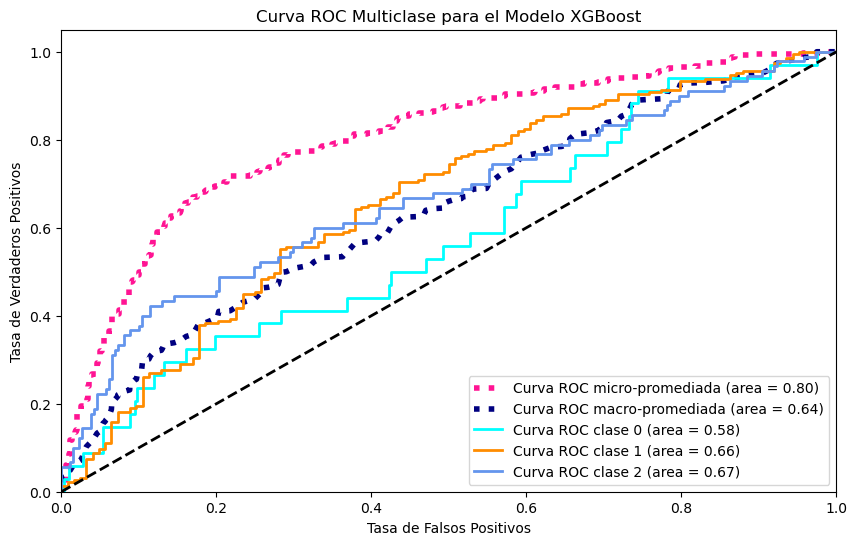

In [67]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarizar las etiquetas para que cada clase sea considerada como "una contra el resto"
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Entrenar el modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predecir las probabilidades para el conjunto de prueba
y_score = xgb_model.predict_proba(X_test)

# Inicializar las variables para la curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular la curva ROC y AUC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (micro y macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Curva ROC micro-promediada (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Curva ROC macro-promediada (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC clase {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase para el Modelo XGBoost')
plt.legend(loc="lower right")
plt.show()

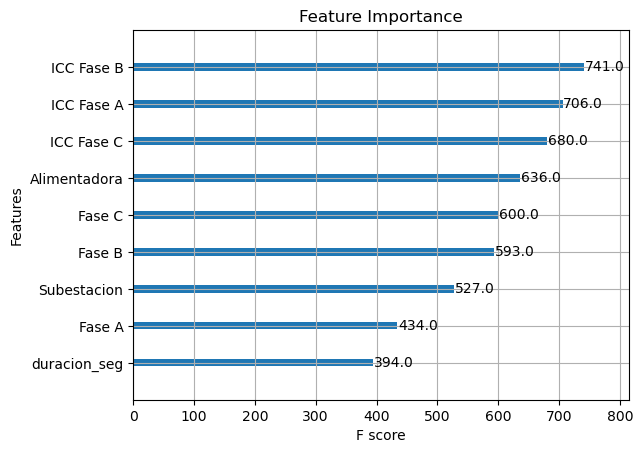

In [68]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Asegúrate de que tu modelo XGBoost ha sido entrenado, ejemplo:
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# xgb_model.fit(X_train, y_train)

# Visualización de la importancia de las características
plot_importance(xgb_model, importance_type='weight')
plt.title('Feature Importance')
plt.show()

# Matrices de Confusión

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, max_depth=100, max_features='log2', random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Entrenar el modelo SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Entrenar el modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)



C:\Users\gach8\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


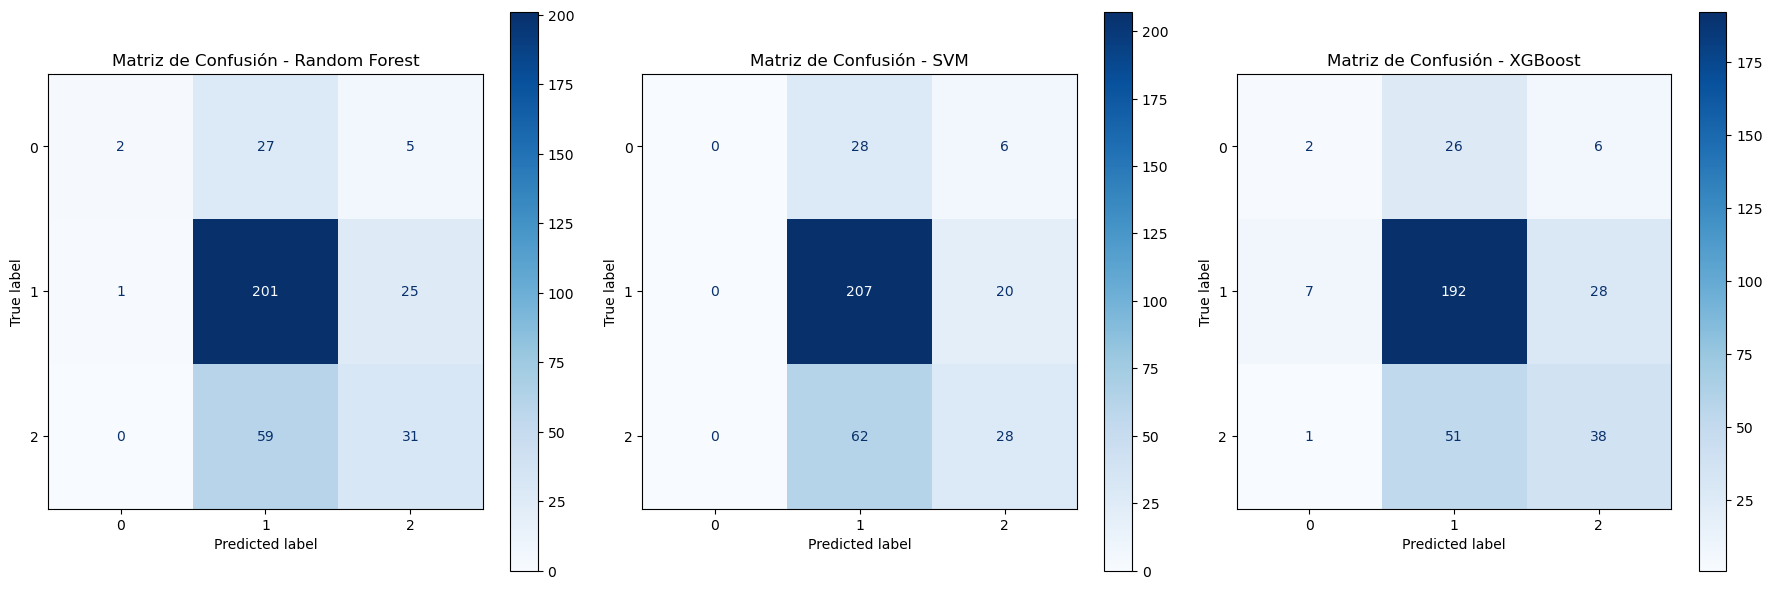

In [70]:
# Calcular las matrices de confusión
rf_cm = confusion_matrix(y_test, rf_pred)
svm_cm = confusion_matrix(y_test, svm_pred)
xgb_cm = confusion_matrix(y_test, xgb_pred)

# Mostrar las matrices de confusión
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest Confusion Matrix
ConfusionMatrixDisplay(rf_cm).plot(ax=ax[0], cmap='Blues', values_format='d')
ax[0].set_title('Matriz de Confusión - Random Forest')

# SVM Confusion Matrix
ConfusionMatrixDisplay(svm_cm).plot(ax=ax[1], cmap='Blues', values_format='d')
ax[1].set_title('Matriz de Confusión - SVM')

# XGBoost Confusion Matrix
ConfusionMatrixDisplay(xgb_cm).plot(ax=ax[2], cmap='Blues', values_format='d')
ax[2].set_title('Matriz de Confusión - XGBoost')

plt.tight_layout()
plt.show()

In [71]:
from sklearn.metrics import classification_report

# Calcular métricas para Random Forest
rf_report = classification_report(y_test, rf_pred, target_names=np.unique(y_train).astype(str), output_dict=True)
print("Métricas para Random Forest:")
print(classification_report(y_test, rf_pred, target_names=np.unique(y_train).astype(str)))

# Calcular métricas para SVM
svm_report = classification_report(y_test, svm_pred, target_names=np.unique(y_train).astype(str), output_dict=True)
print("Métricas para SVM:")
print(classification_report(y_test, svm_pred, target_names=np.unique(y_train).astype(str)))

# Calcular métricas para XGBoost
xgb_report = classification_report(y_test, xgb_pred, target_names=np.unique(y_train).astype(str), output_dict=True)
print("Métricas para XGBoost:")
print(classification_report(y_test, xgb_pred, target_names=np.unique(y_train).astype(str)))

Métricas para Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.06      0.11        34
           1       0.70      0.89      0.78       227
           2       0.51      0.34      0.41        90

    accuracy                           0.67       351
   macro avg       0.63      0.43      0.43       351
weighted avg       0.65      0.67      0.62       351

Métricas para SVM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.70      0.91      0.79       227
           2       0.52      0.31      0.39        90

    accuracy                           0.67       351
   macro avg       0.41      0.41      0.39       351
weighted avg       0.58      0.67      0.61       351

Métricas para XGBoost:
              precision    recall  f1-score   support

           0       0.20      0.06      0.09        34
           1       0.71      0.85      0.77       227
    

C:\Users\gach8\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gach8\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gach8\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gach8\anaconda3\lib\site-packag

In [72]:
pip install memory_profiler

Note: you may need to restart the kernel to use updated packages.


In [73]:
import time
from memory_profiler import memory_usage
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

def train_model(model, X_train, y_train):
    start_time = time.time()  # Inicia el contador de tiempo
    initial_memory = memory_usage()  # Memoria inicial
    
    model.fit(X_train, y_train)  # Entrenamiento del modelo
    
    end_time = time.time()  # Fin del contador de tiempo
    final_memory = memory_usage()  # Memoria final
    
    training_time = end_time - start_time  # Cálculo del tiempo de entrenamiento
    memory_used = final_memory[0] - initial_memory[0]  # Cálculo del uso de memoria
    
    return training_time, memory_used

# Definición de los modelos
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, max_depth=100, max_features='log2', random_state=42)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Mediciones para Random Forest
rf_time, rf_memory = train_model(rf_model, X_train, y_train)
print(f"Random Forest - Tiempo de entrenamiento: {rf_time:.3f} segundos, Uso de memoria: {rf_memory:.3f} MiB")

# Mediciones para SVM
svm_time, svm_memory = train_model(svm_model, X_train, y_train)
print(f"SVM - Tiempo de entrenamiento: {svm_time:.3f} segundos, Uso de memoria: {svm_memory:.3f} MiB")

# Mediciones para XGBoost
xgb_time, xgb_memory = train_model(xgb_model, X_train, y_train)
print(f"XGBoost - Tiempo de entrenamiento: {xgb_time:.3f} segundos, Uso de memoria: {xgb_memory:.3f} MiB")

Random Forest - Tiempo de entrenamiento: 0.512 segundos, Uso de memoria: 0.023 MiB
SVM - Tiempo de entrenamiento: 0.320 segundos, Uso de memoria: 0.016 MiB


C:\Users\gach8\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:03:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Tiempo de entrenamiento: 0.315 segundos, Uso de memoria: 0.016 MiB


Training scores para Learning Curve (Random Forest): [1. 1. 1. 1. 1.]
Cross-validation scores para Learning Curve (Random Forest): [0.34514875 0.63835149 0.65637357 0.67779979 0.68379737]
Training scores para Learning Curve (SVM): [0.7483871  0.66138614 0.65497076 0.6813278  0.69517685]
Cross-validation scores para Learning Curve (SVM): [0.3631048  0.67693775 0.67693775 0.68379737 0.68295734]


C:\Users\gach8\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\gach8\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\gach8\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\gach8\anaconda3\lib\site-packages\

Training scores para Learning Curve (XGBoost): [nan  1.  1.  1.  1.]
Cross-validation scores para Learning Curve (XGBoost): [       nan 0.61353582 0.64612083 0.64781556 0.67352995]


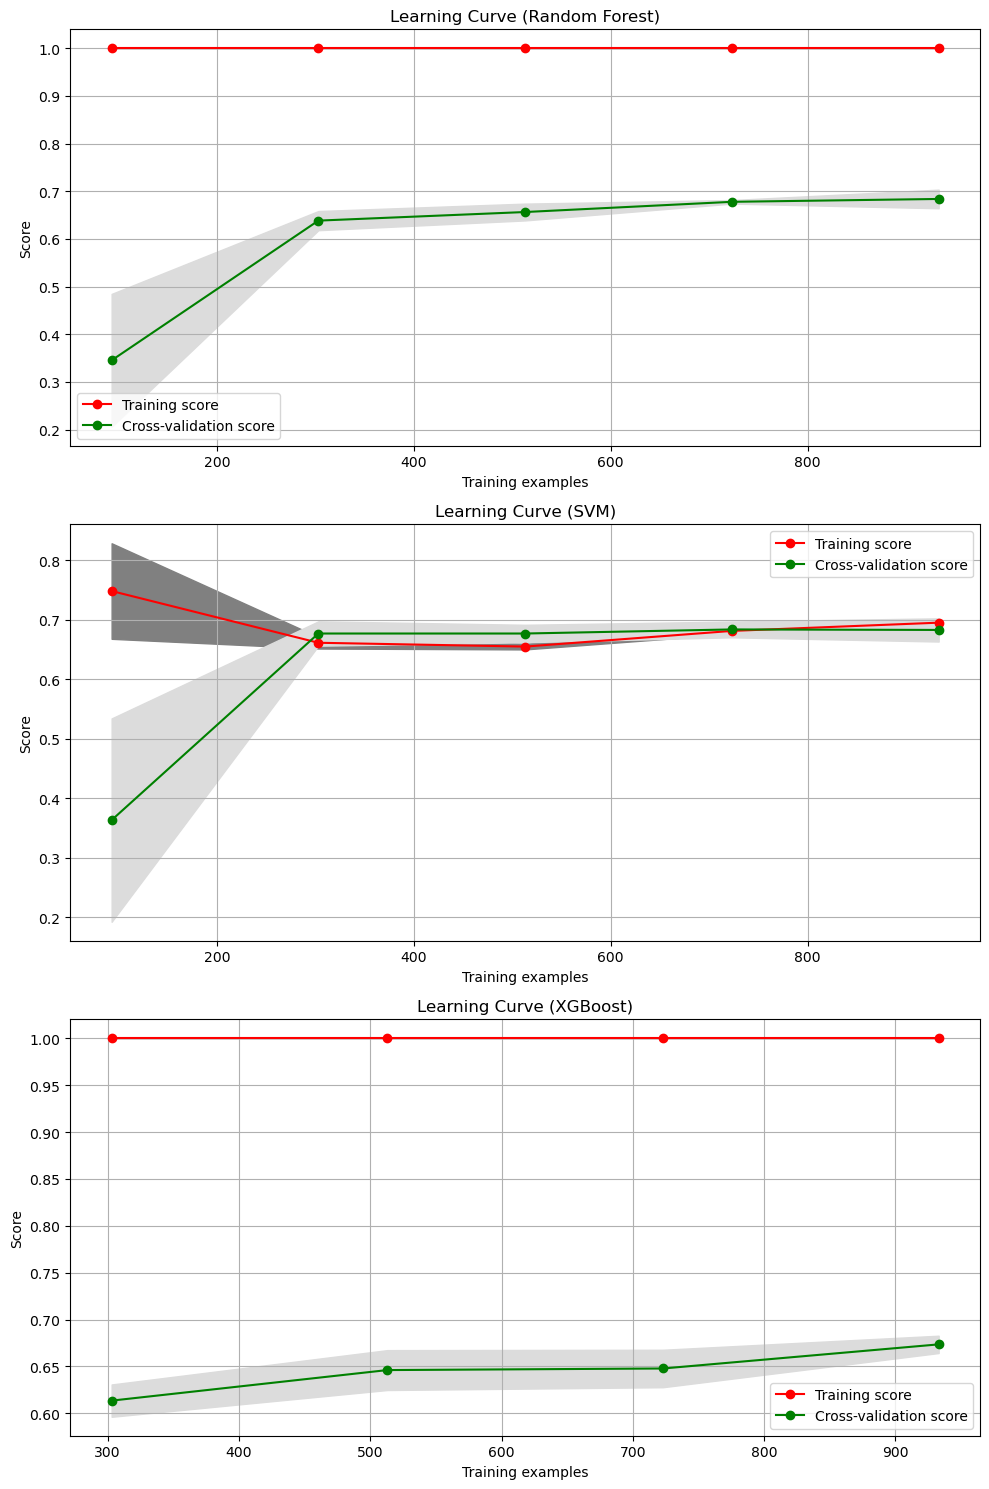

In [74]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(model, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Genera una gráfica simple de la curva de aprendizaje.
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(8, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        model, X, y, cv=5, n_jobs=n_jobs, train_sizes=train_sizes,
        return_times=True, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

     # Imprimir los scores
    print(f"Training scores para {title}: {train_scores_mean}")
    print(f"Cross-validation scores para {title}: {test_scores_mean}")
    
    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, color="gray")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, color="gainsboro")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot learning curve for Random Forest
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X, y, axes=axes[0])

# Plot learning curve for SVM
plot_learning_curve(svm_model, "Learning Curve (SVM)", X, y, axes=axes[1])

# Plot learning curve for XGBoost
plot_learning_curve(xgb_model, "Learning Curve (XGBoost)", X, y, axes=axes[2])

fig.tight_layout()
plt.show()